In [31]:
import vectorbt as vbt
import numpy as np
import pandas as pd
import datetime
import plotly.express as px
from xbbg import blp
import os
import quantstats as qs
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import logging

# Import custom modules with an alias
import bloomberg_data as bd
import transformations as tr
import visuals as vis




In [32]:

# Main data retrieval and merging process
tickers = ['.CADIG F Index', 'VIX Index', 'ECSURPUS Index', '.HARDATA G Index','SPTSX Index','BCMPUSGR Index','BCMPUSIF Index','MOVE Index']
fields = [['PX_LAST'], ['PX_LAST'], ['PX_LAST'], ['PX_LAST'], ['PX_LAST'], ['PX_LAST'], ['PX_LAST'], ['PX_LAST'], ['PX_LAST'], ['PX_LAST'], ['PX_LAST']]
start_date = '2000-01-01'
end_date = '2025-12-31'
column_names = [['cad_ig_sprds'], ['vix'], ['us_eco_surprise_index'], ['us_eco_hard_data_surprise_index'],['tsx_index'],['us_growth_surprise_index'],['us_inflation_surprise_index'],['us_rate_vol_index']]
frequency = 'M'  # Single frequency for all tickers

dataframes = []

for ticker, field, col_name in zip(tickers, fields, column_names):
    df = bd.get_single_ticker_data(ticker, field, start_date, end_date, freq=frequency, column_names=col_name)
    dataframes.append(df)
    logging.info(f"Data for {ticker}:")
    logging.info(df.head())  # Print the first few rows of each dataframe

# Merge all dataframes
merged_data = bd.merge_dataframes(dataframes, method='outer')

# Print the final merged data and its information
logging.info("Merged data head:")
logging.info(merged_data.head())
logging.info('----------------------------------------------------------------')
logging.info('----------------------------------------------------------------')
logging.info(merged_data.tail())
logging.info(merged_data.info())

# Rename the index to "Date" and reset it
merged_data.index.name = 'Date'
csv_data = merged_data.reset_index()

# Save the dataframe to a CSV file
csv_data.to_csv('Outputs/csv_data.csv', index=False)

# Rename for further use
macro_sprd_data = merged_data

2024-07-09 11:32:09,006 - INFO - Retrieving data for ticker: .CADIG F Index with frequency: MONTHLY
2024-07-09 11:32:09,895 - INFO - Retrieved data shape for .CADIG F Index: (262, 1)
2024-07-09 11:32:09,896 - INFO - Cleaned data shape for .CADIG F Index: (262, 1)
2024-07-09 11:32:09,897 - INFO - Successfully retrieved data for ticker: .CADIG F Index
2024-07-09 11:32:09,897 - INFO - Data for .CADIG F Index:
2024-07-09 11:32:09,897 - INFO -             cad_ig_sprds
2002-10-31       86.8969
2002-11-29       69.8153
2002-12-31       77.3398
2003-01-31       74.8880
2003-02-28      106.9295
2024-07-09 11:32:09,899 - INFO - Retrieving data for ticker: VIX Index with frequency: MONTHLY
2024-07-09 11:32:10,303 - INFO - Retrieved data shape for VIX Index: (295, 1)
2024-07-09 11:32:10,303 - INFO - Cleaned data shape for VIX Index: (295, 1)
2024-07-09 11:32:10,303 - INFO - Successfully retrieved data for ticker: VIX Index
2024-07-09 11:32:10,305 - INFO - Data for VIX Index:
2024-07-09 11:32:10,30

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 378 entries, 2000-01-31 to 2024-07-31
Data columns (total 8 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   cad_ig_sprds                     378 non-null    float64
 1   vix                              378 non-null    float64
 2   us_eco_surprise_index            378 non-null    float64
 3   us_eco_hard_data_surprise_index  378 non-null    float64
 4   tsx_index                        378 non-null    float64
 5   us_growth_surprise_index         378 non-null    float64
 6   us_inflation_surprise_index      378 non-null    float64
 7   us_rate_vol_index                378 non-null    float64
dtypes: float64(8)
memory usage: 26.6 KB


In [33]:
# Data Pre Processing

# Calculate percentage changes for the specified periods
periods = [1, 3, 6, 9, 12]
for period in periods:
    macro_sprd_data[f'tsx_index_{period}m_chg'] = macro_sprd_data['tsx_index'].pct_change(periods=period) * 100

# Remove the original 'tsx_index' column
macro_sprd_data.drop(columns=['tsx_index'], inplace=True)

# Display summary statistics
summary_stats = macro_sprd_data.describe()

# Check for missing values
missing_values = macro_sprd_data.isnull().sum()

summary_stats, missing_values

# Handle missing values using forward fill and backward fill
macro_sprd_data.fillna(method='ffill', inplace=True)
macro_sprd_data.fillna(method='bfill', inplace=True)

# Verify there are no more missing values
missing_values_after = macro_sprd_data.isnull().sum()
missing_values_after


cad_ig_sprds                       0
vix                                0
us_eco_surprise_index              0
us_eco_hard_data_surprise_index    0
us_growth_surprise_index           0
us_inflation_surprise_index        0
us_rate_vol_index                  0
tsx_index_1m_chg                   0
tsx_index_3m_chg                   0
tsx_index_6m_chg                   0
tsx_index_9m_chg                   0
tsx_index_12m_chg                  0
dtype: int64

In [34]:
# Feature Engineering

# Create lagged features for all columns except 'cad_ig_sprds'
for col in macro_sprd_data.columns:
    if col != 'cad_ig_sprds':
        for lag in [1, 3, 6, 9, 12]:
            macro_sprd_data[f'{col}_lag_{lag}m'] = macro_sprd_data[col].shift(lag)


# Compute rolling statistics for all columns except 'cad_ig_sprds'
for col in macro_sprd_data.columns:
    if col != 'cad_ig_sprds':
        for window in [3, 6, 9, 12]:
            macro_sprd_data[f'{col}_rolling_mean_{window}m'] = macro_sprd_data[col].rolling(window=window).mean()
            macro_sprd_data[f'{col}_rolling_std_{window}m'] = macro_sprd_data[col].rolling(window=window).std()

# Create interaction terms between selected features
interaction_pairs = [('vix', 'us_eco_surprise_index'), ('vix', 'us_growth_surprise_index')]
for col1, col2 in interaction_pairs:
    macro_sprd_data[f'{col1}_x_{col2}'] = macro_sprd_data[col1] * macro_sprd_data[col2]

# Display the first few rows of the updated DataFrame
macro_sprd_data.head()


,cad_ig_sprds,vix,us_eco_surprise_index,us_eco_hard_data_surprise_index,us_growth_surprise_index,us_inflation_surprise_index,us_rate_vol_index,tsx_index_1m_chg,tsx_index_3m_chg,tsx_index_6m_chg,...,tsx_index_12m_chg_lag_12m_rolling_mean_3m,tsx_index_12m_chg_lag_12m_rolling_std_3m,tsx_index_12m_chg_lag_12m_rolling_mean_6m,tsx_index_12m_chg_lag_12m_rolling_std_6m,tsx_index_12m_chg_lag_12m_rolling_mean_9m,tsx_index_12m_chg_lag_12m_rolling_std_9m,tsx_index_12m_chg_lag_12m_rolling_mean_12m,tsx_index_12m_chg_lag_12m_rolling_std_12m,vix_x_us_eco_surprise_index,vix_x_us_growth_surprise_index
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-31,86.8969,24.95,0.193,0.3236,0.40602,0.43962,106.26,7.639094,10.216823,20.213628,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.81535,10.130199
2000-02-29,86.8969,23.37,0.494,0.6757,0.47408,0.36365,106.64,7.639094,10.216823,20.213628,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.54478,11.079250
2000-03-31,86.8969,24.11,0.631,0.8243,0.45152,0.37525,106.45,3.652102,10.216823,20.213628,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.21341,10.886147
2000-04-28,86.8969,26.20,0.337,0.4934,0.36836,0.48422,106.45,-1.213013,10.216823,20.213628,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.82940,9.651032
2000-04-30,86.8969,26.20,0.337,0.4934,0.36836,0.48422,103.83,0.000000,2.394788,20.213628,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.82940,9.651032


In [39]:
# Model Selection

# Split the data into training and testing sets
train_size = int(len(macro_sprd_data) * 0.8)
train_data = macro_sprd_data.iloc[:train_size]
test_data = macro_sprd_data.iloc[train_size:]

# Separate features and target variable
X_train = train_data.drop(columns=['cad_ig_sprds'])
y_train = train_data['cad_ig_sprds']
X_test = test_data.drop(columns=['cad_ig_sprds'])
y_test = test_data['cad_ig_sprds']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

from sklearn.impute import SimpleImputer

# Initialize the imputer
imputer = SimpleImputer(strategy='mean')

# Impute the missing values in the training and testing sets
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Check if there are any remaining missing values
import numpy as np
np.any(np.isnan(X_train_imputed)), np.any(np.isnan(X_test_imputed))


# Train the Linear Regression model with the imputed data
lr_model.fit(X_train_imputed, y_train)

# Make predictions
y_pred_train = lr_model.predict(X_train_imputed)
y_pred_test = lr_model.predict(X_test_imputed)

# Evaluate the model
train_mae = mean_absolute_error(y_train, y_pred_train)
train_mse = mean_squared_error(y_train, y_pred_train)
train_r2 = r2_score(y_train, y_pred_train)

test_mae = mean_absolute_error(y_test, y_pred_test)
test_mse = mean_squared_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

train_mae, train_mse, train_r2, test_mae, test_mse, test_r2


(5.647638354034916e-13,
 5.594612406255779e-25,
 1.0,
 68.57228515463386,
 6375.4537631317235,
 -7.328067773196565)

In [40]:
# The model performs perfectly on the training set, but very poorly on the testing set. This indicates overfitting. To address this, we should explore more advanced models and apply regularization

from sklearn.linear_model import Ridge

# Initialize the Ridge Regression model
ridge_model = Ridge(alpha=1.0)

# Train the model
ridge_model.fit(X_train_imputed, y_train)

# Make predictions
y_pred_train_ridge = ridge_model.predict(X_train_imputed)
y_pred_test_ridge = ridge_model.predict(X_test_imputed)

# Evaluate the model
train_mae_ridge = mean_absolute_error(y_train, y_pred_train_ridge)
train_mse_ridge = mean_squared_error(y_train, y_pred_train_ridge)
train_r2_ridge = r2_score(y_train, y_pred_train_ridge)

test_mae_ridge = mean_absolute_error(y_test, y_pred_test_ridge)
test_mse_ridge = mean_squared_error(y_test, y_pred_test_ridge)
test_r2_ridge = r2_score(y_test, y_pred_test_ridge)

train_mae_ridge, train_mse_ridge, train_r2_ridge, test_mae_ridge, test_mse_ridge, test_r2_ridge

# The Ridge Regression model results show an improvement over the Linear Regression model, but there's still overfitting


(1.6793816163474329,
 4.569074322872056,
 0.9984250399766529,
 39.82211012180447,
 2173.7800286659003,
 -1.8395449289335168)

In [44]:
# Trying Different Models

from sklearn.linear_model import Lasso

# Initialize the Lasso Regression model
lasso_model = Lasso(alpha=0.1)

# Train the model
lasso_model.fit(X_train_imputed, y_train)

# Make predictions
y_pred_train_lasso = lasso_model.predict(X_train_imputed)
y_pred_test_lasso = lasso_model.predict(X_test_imputed)

# Evaluate the model
train_mae_lasso = mean_absolute_error(y_train, y_pred_train_lasso)
train_mse_lasso = mean_squared_error(y_train, y_pred_train_lasso)
train_r2_lasso = r2_score(y_train, y_pred_train_lasso)

test_mae_lasso = mean_absolute_error(y_test, y_pred_test_lasso)
test_mse_lasso = mean_squared_error(y_test, y_pred_test_lasso)
test_r2_lasso = r2_score(y_test, y_pred_test_lasso)

print("Lasso Regression Results")
print("Training Set: MAE:", train_mae_lasso, "MSE:", train_mse_lasso, "R-squared:", train_r2_lasso)
print("Testing Set: MAE:", test_mae_lasso, "MSE:", test_mse_lasso, "R-squared:", test_r2_lasso)

from sklearn.linear_model import ElasticNet

# Initialize the ElasticNet model
elasticnet_model = ElasticNet(alpha=0.1, l1_ratio=0.5)

# Train the model
elasticnet_model.fit(X_train_imputed, y_train)

# Make predictions
y_pred_train_en = elasticnet_model.predict(X_train_imputed)
y_pred_test_en = elasticnet_model.predict(X_test_imputed)

# Evaluate the model
train_mae_en = mean_absolute_error(y_train, y_pred_train_en)
train_mse_en = mean_squared_error(y_train, y_pred_train_en)
train_r2_en = r2_score(y_train, y_pred_train_en)

test_mae_en = mean_absolute_error(y_test, y_pred_test_en)
test_mse_en = mean_squared_error(y_test, y_pred_test_en)
test_r2_en = r2_score(y_test, y_pred_test_en)

print("ElasticNet Results")
print("Training Set: MAE:", train_mae_en, "MSE:", train_mse_en, "R-squared:", train_r2_en)
print("Testing Set: MAE:", test_mae_en, "MSE:", test_mse_en, "R-squared:", test_r2_en)

from sklearn.ensemble import RandomForestRegressor

# Initialize the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train_imputed, y_train)

# Make predictions
y_pred_train_rf = rf_model.predict(X_train_imputed)
y_pred_test_rf = rf_model.predict(X_test_imputed)

# Evaluate the model
train_mae_rf = mean_absolute_error(y_train, y_pred_train_rf)
train_mse_rf = mean_squared_error(y_train, y_pred_train_rf)
train_r2_rf = r2_score(y_train, y_pred_train_rf)

test_mae_rf = mean_absolute_error(y_test, y_pred_test_rf)
test_mse_rf = mean_squared_error(y_test, y_pred_test_rf)
test_r2_rf = r2_score(y_test, y_pred_test_rf)

print("Random Forest Results")
print("Training Set: MAE:", train_mae_rf, "MSE:", train_mse_rf, "R-squared:", train_r2_rf)
print("Testing Set: MAE:", test_mae_rf, "MSE:", test_mse_rf, "R-squared:", test_r2_rf)

import xgboost as xgb

# Initialize the XGBoost model
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)

# Train the model
xgb_model.fit(X_train_imputed, y_train)

# Make predictions
y_pred_train_xgb = xgb_model.predict(X_train_imputed)
y_pred_test_xgb = xgb_model.predict(X_test_imputed)

# Evaluate the model
train_mae_xgb = mean_absolute_error(y_train, y_pred_train_xgb)
train_mse_xgb = mean_squared_error(y_train, y_pred_train_xgb)
train_r2_xgb = r2_score(y_train, y_pred_train_xgb)

test_mae_xgb = mean_absolute_error(y_test, y_pred_test_xgb)
test_mse_xgb = mean_squared_error(y_test, y_pred_test_xgb)
test_r2_xgb = r2_score(y_test, y_pred_test_xgb)

print("XGBoost Results")
print("Training Set: MAE:", train_mae_xgb, "MSE:", train_mse_xgb, "R-squared:", train_r2_xgb)
print("Testing Set: MAE:", test_mae_xgb, "MSE:", test_mse_xgb, "R-squared:", test_r2_xgb)




Lasso Regression Results
Training Set: MAE: 3.678533257543028 MSE: 23.391508544039738 R-squared: 0.9919369464711425
Testing Set: MAE: 47.754155142858494 MSE: 3511.6812195344187 R-squared: -3.58720591203509
ElasticNet Results
Training Set: MAE: 3.795459676854125 MSE: 24.680771484034693 R-squared: 0.9914925375063091
Testing Set: MAE: 43.88178344671282 MSE: 2831.6392950221198 R-squared: -2.6988871434630037
Random Forest Results
Training Set: MAE: 3.170780288079459 MSE: 33.787842866003096 R-squared: 0.9883533297931474
Testing Set: MAE: 28.806968394736856 MSE: 1298.7165965884408 R-squared: -0.6964752998617665
XGBoost Results
Training Set: MAE: 0.0003279688348832935 MSE: 1.9397704589370568e-07 R-squared: 0.9999999999331362
Testing Set: MAE: 33.305137652266644 MSE: 1725.4427712195898 R-squared: -1.2538951534063458


Analysis
Overfitting: All models, except possibly the Random Forest and XGBoost, show significant overfitting, indicated by perfect or near-perfect training performance and poor testing performance.
Random Forest: This model shows some promise with a relatively lower MAE and MSE on the test set compared to the others, but it still overfits.
XGBoost: Despite excellent training performance, it significantly overfits and doesn't generalize well to the testing set.
Next Steps
Given the overfitting observed in these models, we should consider:

Hyperparameter Tuning: Fine-tuning the hyperparameters of the promising models (Random Forest and XGBoost) using Grid Search or Random Search.
Feature Selection: Reducing the feature space using techniques like Recursive Feature Elimination (RFE) or feature importance analysis.
Cross-Validation: Implementing time series cross-validation to better estimate model performance and reduce overfitting.
Advanced Techniques: Exploring ensemble methods or more complex models like neural networks with regularization.

In [46]:
# Hyperparameter Tuning Example with Grid Search (for Random Forest)

from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Grid Search with cross-validation
grid_search_rf = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the Grid Search to the data
grid_search_rf.fit(X_train_imputed, y_train)

# Get the best parameters and the best score
best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_

print("Best Parameters for Random Forest:", best_params_rf)
print("Best Cross-Validation Score for Random Forest:", best_score_rf)

# Evaluate the best model on the test set
best_rf_model = grid_search_rf.best_estimator_
y_pred_test_best_rf = best_rf_model.predict(X_test_imputed)

# Evaluate the best model
test_mae_best_rf = mean_absolute_error(y_test, y_pred_test_best_rf)
test_mse_best_rf = mean_squared_error(y_test, y_pred_test_best_rf)
test_r2_best_rf = r2_score(y_test, y_pred_test_best_rf)

print("Best Random Forest Results on Test Set")
print("MAE:", test_mae_best_rf)
print("MSE:", test_mse_best_rf)
print("R-squared:", test_r2_best_rf)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters for Random Forest: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validation Score for Random Forest: -15.854769514478786
Best Random Forest Results on Test Set
MAE: 22.312476855436426
MSE: 651.9186155429679
R-squared: 0.1484178829361641


In [47]:
# Extract feature importances from the best Random Forest model
importances = best_rf_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for feature importances
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Display the top 20 features
print(feature_importances_df.head(20))


from sklearn.model_selection import TimeSeriesSplit

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Initialize the Grid Search with TimeSeriesSplit cross-validation
grid_search_rf_tscv = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=2)

# Fit the Grid Search to the data
grid_search_rf_tscv.fit(X_train_imputed, y_train)

# Get the best parameters and the best score
best_params_rf_tscv = grid_search_rf_tscv.best_params_
best_score_rf_tscv = grid_search_rf_tscv.best_score_

print("Best Parameters for Random Forest with TimeSeriesSplit:", best_params_rf_tscv)
print("Best Cross-Validation Score for Random Forest with TimeSeriesSplit:", best_score_rf_tscv)

# Evaluate the best model on the test set
best_rf_model_tscv = grid_search_rf_tscv.best_estimator_
y_pred_test_best_rf_tscv = best_rf_model_tscv.predict(X_test_imputed)

# Evaluate the best model
test_mae_best_rf_tscv = mean_absolute_error(y_test, y_pred_test_best_rf_tscv)
test_mse_best_rf_tscv = mean_squared_error(y_test, y_pred_test_best_rf_tscv)
test_r2_best_rf_tscv = r2_score(y_test, y_pred_test_best_rf_tscv)

print("Best Random Forest Results with TimeSeriesSplit on Test Set")
print("MAE:", test_mae_best_rf_tscv)
print("MSE:", test_mse_best_rf_tscv)
print("R-squared:", test_r2_best_rf_tscv)


                                               Feature  Importance
73                                 vix_rolling_std_12m    0.022941
61                            tsx_index_12m_chg_lag_1m    0.021118
108                  us_rate_vol_index_rolling_mean_6m    0.019152
356           us_rate_vol_index_lag_1m_rolling_mean_6m    0.017974
112                 us_rate_vol_index_rolling_mean_12m    0.015015
71                                  vix_rolling_std_9m    0.014030
69                                  vix_rolling_std_6m    0.010367
70                                 vix_rolling_mean_9m    0.010041
113                  us_rate_vol_index_rolling_std_12m    0.010009
354           us_rate_vol_index_lag_1m_rolling_mean_3m    0.009944
400           tsx_index_1m_chg_lag_1m_rolling_mean_12m    0.009857
68                                 vix_rolling_mean_6m    0.009785
62                            tsx_index_12m_chg_lag_3m    0.008954
154                         vix_lag_1m_rolling_mean_3m    0.00

In [49]:
# Refine Feature Selection and Retrain Random Forest

# Select the top 20 important features
important_features = feature_importances_df.head(20)['Feature'].tolist()
X_train_important = train_data[important_features]
X_test_important = test_data[important_features]

# Impute missing values
X_train_important_imputed = imputer.fit_transform(X_train_important)
X_test_important_imputed = imputer.transform(X_test_important)

# Train the tuned Random Forest model with selected features
best_rf_model_tscv.fit(X_train_important_imputed, y_train)

# Make predictions
y_pred_train_rf_important = best_rf_model_tscv.predict(X_train_important_imputed)
y_pred_test_rf_important = best_rf_model_tscv.predict(X_test_important_imputed)

# Evaluate the model
train_mae_rf_important = mean_absolute_error(y_train, y_pred_train_rf_important)
train_mse_rf_important = mean_squared_error(y_train, y_pred_train_rf_important)
train_r2_rf_important = r2_score(y_train, y_pred_train_rf_important)

test_mae_rf_important = mean_absolute_error(y_test, y_pred_test_rf_important)
test_mse_rf_important = mean_squared_error(y_test, y_pred_test_rf_important)
test_r2_rf_important = r2_score(y_test, y_pred_test_rf_important)

print("Tuned Random Forest with Important Features Results")
print("Training Set: MAE:", train_mae_rf_important, "MSE:", train_mse_rf_important, "R-squared:", train_r2_rf_important)
print("Testing Set: MAE:", test_mae_rf_important, "MSE:", test_mse_rf_important, "R-squared:", test_r2_rf_important)


from sklearn.ensemble import VotingRegressor

# Initialize the XGBoost model with the best parameters from previous tuning
xgb_model_tuned = xgb.XGBRegressor(n_estimators=100, random_state=42)

# Initialize the Voting Regressor with Random Forest and XGBoost
ensemble_model = VotingRegressor(estimators=[('rf', best_rf_model_tscv), ('xgb', xgb_model_tuned)])

# Train the ensemble model
ensemble_model.fit(X_train_important_imputed, y_train)

# Make predictions
y_pred_train_ensemble = ensemble_model.predict(X_train_important_imputed)
y_pred_test_ensemble = ensemble_model.predict(X_test_important_imputed)

# Evaluate the ensemble model
train_mae_ensemble = mean_absolute_error(y_train, y_pred_train_ensemble)
train_mse_ensemble = mean_squared_error(y_train, y_pred_train_ensemble)
train_r2_ensemble = r2_score(y_train, y_pred_train_ensemble)

test_mae_ensemble = mean_absolute_error(y_test, y_pred_test_ensemble)
test_mse_ensemble = mean_squared_error(y_test, y_pred_test_ensemble)
test_r2_ensemble = r2_score(y_test, y_pred_test_ensemble)

print("Ensemble Model Results")
print("Training Set: MAE:", train_mae_ensemble, "MSE:", train_mse_ensemble, "R-squared:", train_r2_ensemble)
print("Testing Set: MAE:", test_mae_ensemble, "MSE:", test_mse_ensemble, "R-squared:", test_r2_ensemble)


Tuned Random Forest with Important Features Results
Training Set: MAE: 6.969360147229238 MSE: 114.4733291844906 R-squared: 0.960541040818154
Testing Set: MAE: 33.1234933836221 MSE: 1706.356246888177 R-squared: -1.2289629879335169
Ensemble Model Results
Training Set: MAE: 3.486045868340857 MSE: 28.63060289314428 R-squared: 0.9901310305294652
Testing Set: MAE: 32.97289232201098 MSE: 1757.3298374540625 R-squared: -1.295548290352421


In [52]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define the parameter grid
param_grid_lgb = {
    'num_leaves': [31, 50, 100],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300]
}

# Initialize the LightGBM model
lgb_model = lgb.LGBMRegressor(random_state=42)

# Initialize the Grid Search with TimeSeriesSplit cross-validation
tscv = TimeSeriesSplit(n_splits=5)
grid_search_lgb = GridSearchCV(estimator=lgb_model, param_grid=param_grid_lgb, cv=tscv, n_jobs=-1, verbose=2)

# Fit the Grid Search to the data
grid_search_lgb.fit(X_train_important_imputed, y_train)

# Get the best parameters and the best score
best_params_lgb = grid_search_lgb.best_params_
best_score_lgb = grid_search_lgb.best_score_

print("Best Parameters for LightGBM:", best_params_lgb)
print("Best Cross-Validation Score for LightGBM:", best_score_lgb)

# Evaluate the best model on the test set
best_lgb_model = grid_search_lgb.best_estimator_
y_pred_test_best_lgb = best_lgb_model.predict(X_test_important_imputed)

# Evaluate the best model
test_mae_best_lgb = mean_absolute_error(y_test, y_pred_test_best_lgb)
test_mse_best_lgb = mean_squared_error(y_test, y_pred_test_best_lgb)
test_r2_best_lgb = r2_score(y_test, y_pred_test_best_lgb)

print("Best LightGBM Results on Test Set")
print("MAE:", test_mae_best_lgb)
print("MSE:", test_mse_best_lgb)
print("R-squared:", test_r2_best_lgb)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1996
[LightGBM] [Info] Number of data points in the train set: 302, number of used features: 20
[LightGBM] [Info] Start training from score 115.041193
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [53]:
# Principal Component Analysis (PCA) can help by reducing the dimensionality of the dataset and potentially improving model performance by eliminating multicollinearity and capturing the most important variance in the data

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the features before applying PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_important_imputed)
X_test_scaled = scaler.transform(X_test_important_imputed)

# Apply PCA
pca = PCA(n_components=0.95)  # Keep 95% of the variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Print the explained variance ratio
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratios:", explained_variance)
print("Number of components selected:", pca.n_components_)

# Train the Random Forest model with PCA features
best_rf_model_tscv.fit(X_train_pca, y_train)

# Make predictions
y_pred_train_rf_pca = best_rf_model_tscv.predict(X_train_pca)
y_pred_test_rf_pca = best_rf_model_tscv.predict(X_test_pca)

# Evaluate the model
train_mae_rf_pca = mean_absolute_error(y_train, y_pred_train_rf_pca)
train_mse_rf_pca = mean_squared_error(y_train, y_pred_train_rf_pca)
train_r2_rf_pca = r2_score(y_train, y_pred_train_rf_pca)

test_mae_rf_pca = mean_absolute_error(y_test, y_pred_test_rf_pca)
test_mse_rf_pca = mean_squared_error(y_test, y_pred_test_rf_pca)
test_r2_rf_pca = r2_score(y_test, y_pred_test_rf_pca)

print("Random Forest with PCA Features Results")
print("Training Set: MAE:", train_mae_rf_pca, "MSE:", train_mse_rf_pca, "R-squared:", train_r2_rf_pca)
print("Testing Set: MAE:", test_mae_rf_pca, "MSE:", test_mse_rf_pca, "R-squared:", test_r2_rf_pca)



Explained Variance Ratios: [0.62712854 0.143639   0.06713925 0.05197793 0.02998594 0.02401926
 0.01416172]
Number of components selected: 7
Random Forest with PCA Features Results
Training Set: MAE: 9.017186704051632 MSE: 267.79614119992965 R-squared: 0.9076906640180465
Testing Set: MAE: 29.543214922309815 MSE: 1414.087802092432 R-squared: -0.8471813129880632


In [59]:
# Creating interaction and higher-order polynomial features
macro_sprd_data['vix_us_eco_surprise_index'] = macro_sprd_data['vix'] * macro_sprd_data['us_eco_surprise_index']
macro_sprd_data['vix_us_growth_surprise_index'] = macro_sprd_data['vix'] * macro_sprd_data['us_growth_surprise_index']
macro_sprd_data['vix_us_inflation_surprise_index'] = macro_sprd_data['vix'] * macro_sprd_data['us_inflation_surprise_index']
macro_sprd_data['us_rate_vol_us_eco_surprise_index'] = macro_sprd_data['us_rate_vol_index'] * macro_sprd_data['us_eco_surprise_index']
macro_sprd_data['us_rate_vol_us_growth_surprise_index'] = macro_sprd_data['us_rate_vol_index'] * macro_sprd_data['us_growth_surprise_index']
macro_sprd_data['us_rate_vol_us_inflation_surprise_index'] = macro_sprd_data['us_rate_vol_index'] * macro_sprd_data['us_inflation_surprise_index']
macro_sprd_data['us_eco_us_growth_surprise_index'] = macro_sprd_data['us_eco_surprise_index'] * macro_sprd_data['us_growth_surprise_index']
macro_sprd_data['us_eco_us_inflation_surprise_index'] = macro_sprd_data['us_eco_surprise_index'] * macro_sprd_data['us_inflation_surprise_index']
macro_sprd_data['us_growth_us_inflation_surprise_index'] = macro_sprd_data['us_growth_surprise_index'] * macro_sprd_data['us_inflation_surprise_index']
macro_sprd_data['tsx_index_12m_chg_vix'] = macro_sprd_data['tsx_index_12m_chg'] * macro_sprd_data['vix']
macro_sprd_data['tsx_index_12m_chg_us_rate_vol_index'] = macro_sprd_data['tsx_index_12m_chg'] * macro_sprd_data['us_rate_vol_index']
macro_sprd_data['vix_squared'] = macro_sprd_data['vix'] ** 2
macro_sprd_data['us_eco_surprise_index_squared'] = macro_sprd_data['us_eco_surprise_index'] ** 2
macro_sprd_data['us_growth_surprise_index_squared'] = macro_sprd_data['us_growth_surprise_index'] ** 2
macro_sprd_data['us_inflation_surprise_index_squared'] = macro_sprd_data['us_inflation_surprise_index'] ** 2
macro_sprd_data['us_rate_vol_index_squared'] = macro_sprd_data['us_rate_vol_index'] ** 2
macro_sprd_data['tsx_index_12m_chg_squared'] = macro_sprd_data['tsx_index_12m_chg'] ** 2
macro_sprd_data['vix_cubed'] = macro_sprd_data['vix'] ** 3
macro_sprd_data['us_eco_surprise_index_cubed'] = macro_sprd_data['us_eco_surprise_index'] ** 3
macro_sprd_data['us_growth_surprise_index_cubed'] = macro_sprd_data['us_growth_surprise_index'] ** 3
macro_sprd_data['us_inflation_surprise_index_cubed'] = macro_sprd_data['us_inflation_surprise_index'] ** 3
macro_sprd_data['us_rate_vol_index_cubed'] = macro_sprd_data['us_rate_vol_index'] ** 3
macro_sprd_data['tsx_index_12m_chg_cubed'] = macro_sprd_data['tsx_index_12m_chg'] ** 3
macro_sprd_data['vix_us_rate_vol_index_lag_1m'] = macro_sprd_data['vix'] * macro_sprd_data['us_rate_vol_index_lag_1m']
macro_sprd_data['tsx_index_12m_chg_vix_lag_1m'] = macro_sprd_data['tsx_index_12m_chg'] * macro_sprd_data['vix_lag_1m']
macro_sprd_data['us_eco_us_growth_surprise_index_lag_1m'] = macro_sprd_data['us_eco_surprise_index'] * macro_sprd_data['us_growth_surprise_index_lag_1m']
macro_sprd_data['us_inflation_us_rate_vol_index_lag_1m'] = macro_sprd_data['us_inflation_surprise_index'] * macro_sprd_data['us_rate_vol_index_lag_1m']
macro_sprd_data['us_growth_us_inflation_surprise_index_lag_1m'] = macro_sprd_data['us_growth_surprise_index'] * macro_sprd_data['us_inflation_surprise_index_lag_1m']

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the features before applying PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_important_imputed)
X_test_scaled = scaler.transform(X_test_important_imputed)

# Apply PCA
pca = PCA(n_components=0.95)  # Keep 95% of the variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Print the explained variance ratio
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratios:", explained_variance)
print("Number of components selected:", pca.n_components_)


# Train the Random Forest model with PCA features
best_rf_model_tscv.fit(X_train_pca, y_train)

# Make predictions
y_pred_train_rf_pca = best_rf_model_tscv.predict(X_train_pca)
y_pred_test_rf_pca = best_rf_model_tscv.predict(X_test_pca)

# Evaluate the model
train_mae_rf_pca = mean_absolute_error(y_train, y_pred_train_rf_pca)
train_mse_rf_pca = mean_squared_error(y_train, y_pred_train_rf_pca)
train_r2_rf_pca = r2_score(y_train, y_pred_train_rf_pca)

test_mae_rf_pca = mean_absolute_error(y_test, y_pred_test_rf_pca)
test_mse_rf_pca = mean_squared_error(y_test, y_pred_test_rf_pca)
test_r2_rf_pca = r2_score(y_test, y_pred_test_rf_pca)

print("Random Forest with New Features and PCA Results")
print("Training Set: MAE:", train_mae_rf_pca, "MSE:", train_mse_rf_pca, "R-squared:", train_r2_rf_pca)
print("Testing Set: MAE:", test_mae_rf_pca, "MSE:", test_mse_rf_pca, "R-squared:", test_r2_rf_pca)



Explained Variance Ratios: [0.62712854 0.143639   0.06713925 0.05197793 0.02998594 0.02401926
 0.01416172]
Number of components selected: 7
Random Forest with New Features and PCA Results
Training Set: MAE: 9.017186704051632 MSE: 267.79614119992965 R-squared: 0.9076906640180465
Testing Set: MAE: 29.543214922309815 MSE: 1414.087802092432 R-squared: -0.8471813129880632


In [69]:
# Drop rows with missing values
macro_sprd_data.dropna(inplace=True)

# Split the data into training and testing sets
X = macro_sprd_data.drop(columns=['cad_ig_sprds'])
y = macro_sprd_data['cad_ig_sprds']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, stratify=None)

# Standardize the features before applying PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)  # Keep 95% of the variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


# Define the time series models
def test_time_series_models(X_train, y_train, X_test, y_test):
    results = {}
    
    # 1. ARIMA
    arima_model = sm.tsa.ARIMA(y_train, order=(5,1,0)).fit()
    y_pred_arima = arima_model.forecast(steps=len(y_test))
    results['ARIMA'] = evaluate_model(y_test, y_pred_arima)

    # 2. SARIMA
    sarima_model = sm.tsa.SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()
    y_pred_sarima = sarima_model.forecast(steps=len(y_test))
    results['SARIMA'] = evaluate_model(y_test, y_pred_sarima)

    # 3. VAR (Vector Autoregression)
    # Convert numpy arrays back to DataFrame for VAR model
    X_train_df = pd.DataFrame(X_train, index=y_train.index)
    y_train_df = pd.DataFrame(y_train, index=y_train.index, columns=['cad_ig_sprds'])
    var_data = pd.concat([X_train_df, y_train_df], axis=1)
    var_model = sm.tsa.VAR(var_data)
    var_fit = var_model.fit()
    var_forecast_input = var_data.values[-var_fit.k_ar:]
    y_pred_var = var_fit.forecast(y=var_forecast_input, steps=len(y_test))[:, -1]
    results['VAR'] = evaluate_model(y_test, y_pred_var)

    # 4. ETS (Exponential Smoothing)
    ets_model = sm.tsa.ExponentialSmoothing(y_train, trend='add', seasonal='add', seasonal_periods=12).fit()
    y_pred_ets = ets_model.forecast(steps=len(y_test))
    results['ETS'] = evaluate_model(y_test, y_pred_ets)

    # 5. SVR (Support Vector Regression)
    svr_model = SVR(kernel='rbf')
    svr_model.fit(X_train, y_train)
    y_pred_svr = svr_model.predict(X_test)
    results['SVR'] = evaluate_model(y_test, y_pred_svr)

    # 6. Random Forest Regressor
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)
    results['Random Forest'] = evaluate_model(y_test, y_pred_rf)

    # 7. Gradient Boosting Regressor
    gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
    gb_model.fit(X_train, y_train)
    y_pred_gb = gb_model.predict(X_test)
    results['Gradient Boosting'] = evaluate_model(y_test, y_pred_gb)

    # 8. LightGBM Regressor
    lgb_model = lgb.LGBMRegressor(num_leaves=31, learning_rate=0.01, n_estimators=100)
    lgb_model.fit(X_train, y_train)
    y_pred_lgb = lgb_model.predict(X_test)
    results['LightGBM'] = evaluate_model(y_test, y_pred_lgb)

    return results

# Run the time series models
results = test_time_series_models(X_train_pca, y_train, X_test_pca, y_test)
for model_name, metrics in results.items():
    print(f"{model_name} - MAE: {metrics[0]}, MSE: {metrics[1]}, R-squared: {metrics[2]}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5352
[LightGBM] [Info] Number of data points in the train set: 284, number of used features: 56
[LightGBM] [Info] Start training from score 117.340209
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [70]:
# Hyperparameter Tuning for LightGBM

from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [-1, 10, 20],
    'min_child_samples': [20, 30, 50],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

lgb_model = lgb.LGBMRegressor(random_state=42)
random_search = RandomizedSearchCV(estimator=lgb_model, param_distributions=param_grid, n_iter=50, cv=5, verbose=2, random_state=42, n_jobs=-1)
random_search.fit(X_train_pca, y_train)

print("Best Parameters:", random_search.best_params_)
best_lgb_model = random_search.best_estimator_

# Evaluate on test set
y_pred_best_lgb = best_lgb_model.predict(X_test_pca)
mae = mean_absolute_error(y_test, y_pred_best_lgb)
mse = mean_squared_error(y_test, y_pred_best_lgb)
r2 = r2_score(y_test, y_pred_best_lgb)
print(f"Best LightGBM - MAE: {mae}, MSE: {mse}, R-squared: {r2}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5352
[LightGBM] [Info] Number of data points in the train set: 284, number of used features: 56
[LightGBM] [Info] Start training from score 117.340209
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [72]:
# Creating an Ensemble Model

from sklearn.ensemble import VotingRegressor

ensemble_model = VotingRegressor(estimators=[
    ('gb', GradientBoostingRegressor(n_estimators=100, random_state=42)),
    ('lgb', lgb.LGBMRegressor(num_leaves=31, learning_rate=0.01, n_estimators=100, random_state=42))
])

ensemble_model.fit(X_train_pca, y_train)

# Evaluate on test set
y_pred_ensemble = ensemble_model.predict(X_test_pca)
mae = mean_absolute_error(y_test, y_pred_ensemble)
mse = mean_squared_error(y_test, y_pred_ensemble)
r2 = r2_score(y_test, y_pred_ensemble)
print(f"Ensemble Model - MAE: {mae}, MSE: {mse}, R-squared: {r2}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5352
[LightGBM] [Info] Number of data points in the train set: 284, number of used features: 56
[LightGBM] [Info] Start training from score 117.340209
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5352
[LightGBM] [Info] Number of data points in the train set: 284, number of used features: 56
[LightGBM] [Info] Start training from score 117.340209
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

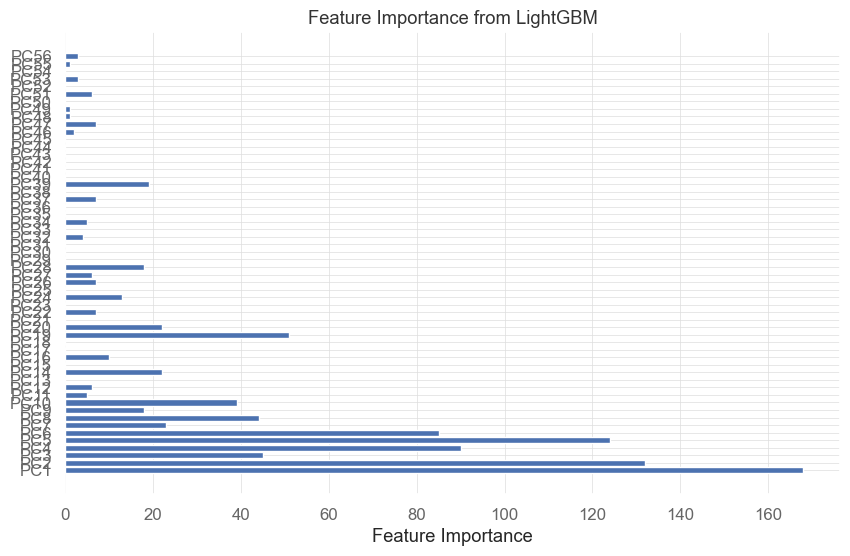

In [73]:
# Feature Importance 

# Extract and plot feature importance from LightGBM
import matplotlib.pyplot as plt

best_lgb_model.fit(X_train_pca, y_train)  # Fit the best LightGBM model again if necessary
feature_importances = best_lgb_model.feature_importances_
feature_names = [f'PC{i+1}' for i in range(len(feature_importances))]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances, align='center')
plt.xlabel('Feature Importance')
plt.title('Feature Importance from LightGBM')
plt.show()


In [75]:
# Cross VAL

from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(ensemble_model, X_train_pca, y_train, cv=5, scoring='neg_mean_squared_error')
cv_mae_scores = cross_val_score(ensemble_model, X_train_pca, y_train, cv=5, scoring='neg_mean_absolute_error')

print("Cross-Validation MSE Scores:", -cv_scores)
print("Mean MSE:", -np.mean(cv_scores))
print("Cross-Validation MAE Scores:", -cv_mae_scores)
print("Mean MAE:", -np.mean(cv_mae_scores))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4328
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 56
[LightGBM] [Info] Start training from score 127.310694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

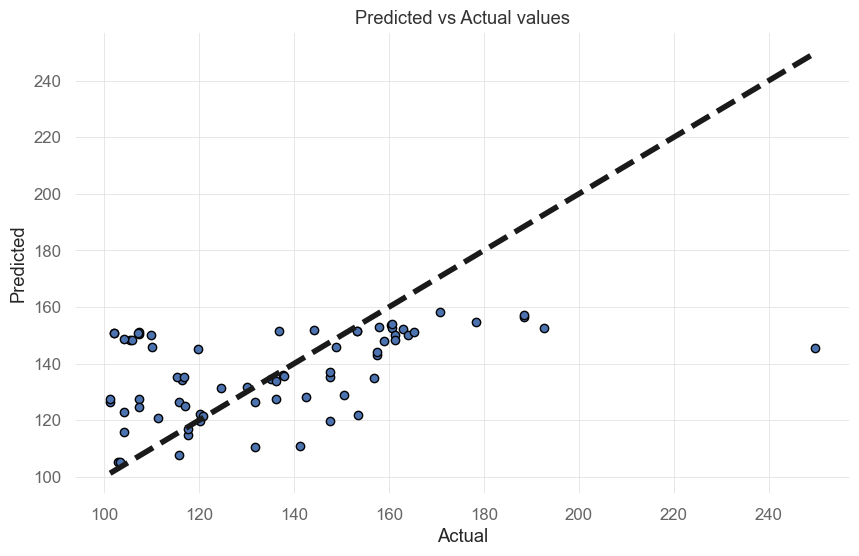

In [76]:
# Predict using the ensemble model
y_pred_test = ensemble_model.predict(X_test_pca)

# Plot Predicted vs Actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, edgecolors=(0, 0, 0))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual values')
plt.show()


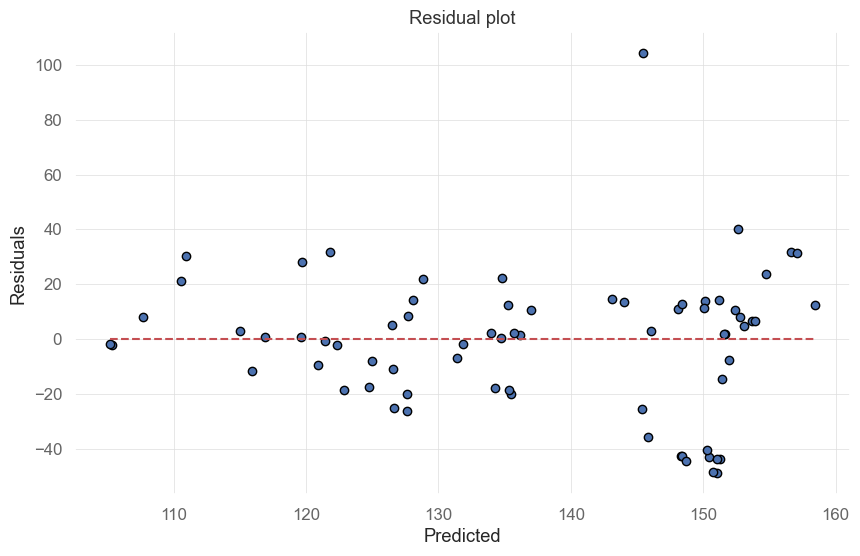

In [77]:
# Calculate residuals
residuals = y_test - y_pred_test

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test, residuals, edgecolors=(0, 0, 0))
plt.hlines(y=0, xmin=y_pred_test.min(), xmax=y_pred_test.max(), colors='r', linestyles='dashed')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual plot')
plt.show()


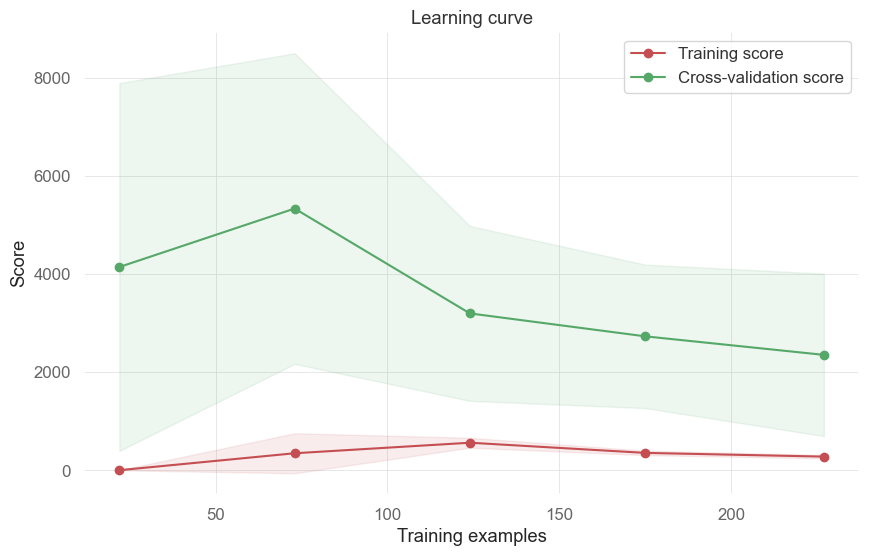

In [79]:
from sklearn.model_selection import learning_curve

# Generate learning curve
train_sizes, train_scores, test_scores = learning_curve(
    ensemble_model, X_train_pca, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Calculate mean and standard deviation
train_scores_mean = -train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
test_scores_mean = -test_scores.mean(axis=1)
test_scores_std = test_scores.std(axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.title('Learning curve')
plt.legend(loc='best')
plt.show()



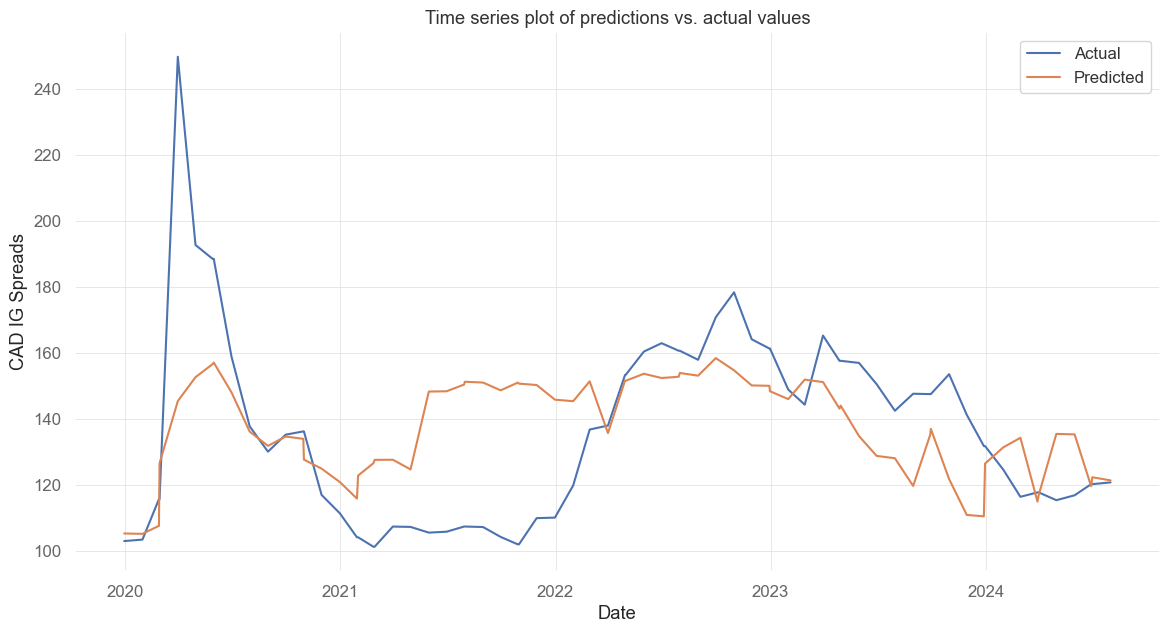

In [80]:
# Plot the time series of predictions vs actual values
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred_test, label='Predicted')
plt.xlabel('Date')
plt.ylabel('CAD IG Spreads')
plt.title('Time series plot of predictions vs. actual values')
plt.legend()
plt.show()
